In [2]:
import numpy as np
import pandas as pd
import random
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr, spearmanr
from warnings import filterwarnings
filterwarnings('ignore')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch CUDA Version: {torch.version.cuda}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

PyTorch Version: 2.9.0+cu126
PyTorch CUDA Version: 12.6
Is CUDA available? True


In [3]:
# Set up device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load data
train = json.load(open("data/train_data.json"))
test = json.load(open("data/test_data.json"))
metric_embs = np.load("data/metric_name_embeddings.npy")
metric_map = json.load(open("data/metric_names.json"))

In [ ]:
# Define degenerate response strategies
# 1. "I don't know" responses
DEGENERATE_RESPONSES = [
    "I cannot help with that.",
    "...",
    "Sorry, I don't understand.",
    "OK.",
    "",
    "This is not a valid question.",
    "I am unable to process this request.",
    "nan"
]

# 2. "Jumble" response function
def jumble_response(text):
    """Shuffles the words in a given text string."""
    words = text.split()
    if len(words) < 2:
        return text
    random.shuffle(words)
    return " ".join(words)

# 3. "1/4" response (Truncate) function
def truncate_response(text):
    """Keeps only the first 1/4 of the words in a string."""
    if text == "" or text is None:
        return text
    words = text.split()
    quarter_len = max(1, len(words) // 4) # Get 25% of words, or at least 1
    return " ".join(words[:quarter_len])

AUGMENTATION_PROBABILITY = 1.0

In [ ]:
# --- Prepare training data (Now with augmentation) ---
model = SentenceTransformer("l3cube-pune/indic-sentence-similarity-sbert", device=device)
X, y = [], []
print("Preparing training data with varied, probabilistic augmentation...")

for r in tqdm(train):
    # 1. Add the ORIGINAL (good) data point
    original_response = r['response']
    txt_good = f"{r['system_prompt']} [SEP] {r['user_prompt']} [SEP] {original_response}"
    text_emb_good = model.encode(txt_good, normalize_embeddings=True)
    metric_emb = metric_embs[metric_map.index(r['metric_name'])]
    
    X.append(np.concatenate([text_emb_good, metric_emb]))
    y.append(r['score'])

    # 2. Add a RANDOMLY AUGMENTED data point
    if random.random() < AUGMENTATION_PROBABILITY:
        # Randomly pick which type of "bad" response to create
        aug_type = random.choice(['idk', 'jumble', 'truncate'])
        
        if aug_type == 'idk':
            new_response = random.choice(DEGENERATE_RESPONSES)
            new_score = 0.0
        
        elif aug_type == 'jumble':
            new_response = jumble_response(original_response)
            new_score = 1.0
            
        else: # aug_type == 'truncate'
            new_response = truncate_response(original_response)
            # We assign a low score of 1.0, interpreting "1/4 response.
            new_score = np.random.normal(loc=2.0, scale=0.5) 
        
        # Create the text for the augmented response
        txt_augmented = f"{r['system_prompt']} [SEP] {r['user_prompt']} [SEP] {new_response}"
        
        # Encode it
        text_emb_augmented = model.encode(txt_augmented, normalize_embeddings=True)
        
        # Append the new augmented data point
        X.append(np.concatenate([text_emb_augmented, metric_emb])) # Re-use metric_emb
        y.append(new_score)


X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(f"Data preparation complete. New training set size: {len(X)}")

# --- Prepare test data (No change here) ---
print("Preparing test data...")
X_test= []
for r in tqdm(test):
    txt = f"{r['system_prompt']} [SEP] {r['user_prompt']} [SEP] {r['response']}"
    text_emb = model.encode(txt, normalize_embeddings=True)
    metric_emb = metric_embs[metric_map.index(r['metric_name'])]
    X_test.append(np.concatenate([text_emb, metric_emb]))

X_test = np.array(X_test, dtype=np.float32)
print("Test data preparation complete.")

Preparing training data with varied, probabilistic augmentation...


100%|██████████| 5000/5000 [04:59<00:00, 16.68it/s]


Data preparation complete. New training set size: 5000
Preparing test data...


100%|██████████| 3638/3638 [02:04<00:00, 29.12it/s]

Test data preparation complete.


In [ ]:
# This works. Don't change it.
# Model for embeddings
model = SentenceTransformer("l3cube-pune/indic-sentence-similarity-sbert", device=device)

# Prepare training data
X, y = [], []
for r in train:
    txt = f"{r['system_prompt']} [SEP] {r['user_prompt']} [SEP] {r['response']}"
    text_emb = model.encode(txt, normalize_embeddings=True)
    metric_emb = metric_embs[metric_map.index(r['metric_name'])]
    X.append(np.concatenate([text_emb, metric_emb]))
    y.append(r['score'])

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Prepare test data
X_test= []
for r in test:
    txt = f"{r['system_prompt']} [SEP] {r['user_prompt']} [SEP] {r['response']}"
    text_emb = model.encode(txt, normalize_embeddings=True)
    metric_emb = metric_embs[metric_map.index(r['metric_name'])]
    X_test.append(np.concatenate([text_emb, metric_emb]))

X_test = np.array(X_test, dtype=np.float32)

NameError: name 'SentenceTransformer' is not defined

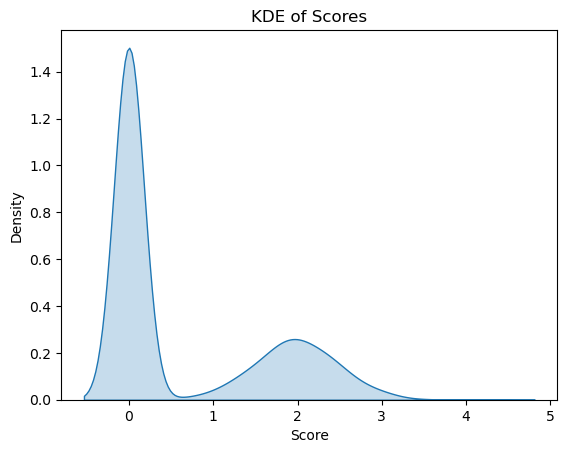

In [ ]:
# KDE plot for scores
sns.kdeplot(y, fill=True)
plt.title("KDE of Scores")
plt.xlabel("Score") 
plt.ylabel("Density")
plt.show()

<AxesSubplot: >

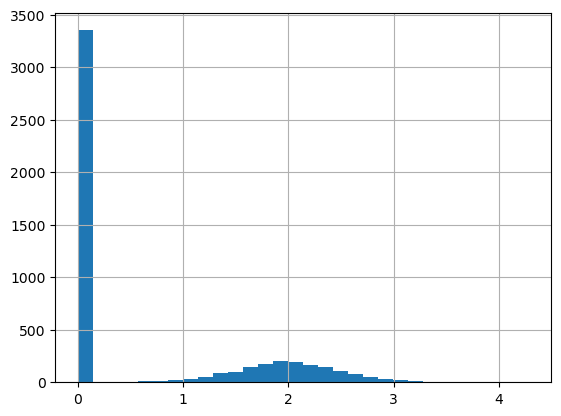

In [8]:
y = pd.Series(y)
y.hist(bins=30)

In [ ]:
from sklearn.linear_model import Ridge
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Train Ridge regressor
reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
pred = reg.predict(X_val)
print("RMSE:", root_mean_squared_error(y_val, pred))

RMSE: 0.8275595307350159


In [37]:
from sklearn.linear_model import HuberRegressor

# Train Huber regressor
reg = HuberRegressor(alpha=1e-3, epsilon=1.35, max_iter=1000)
reg.fit(X_train, y_train)
pred = reg.predict(X_val)
print("RMSE:", root_mean_squared_error(y_val, pred))

RMSE: 1.0774074941244567


In [ ]:
from sklearn.isotonic import IsotonicRegression

# Calibrate using Isotonic Regression
pred_val = reg.predict(X_val)
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(pred_val, y_val)
calibrated_val = iso.transform(pred_val)
print("Calibrated RMSE:", root_mean_squared_error(y_val, calibrated_val))

In [ ]:
# KDE plot for scores
sns.kdeplot(calibrated_val, fill=True)
plt.title("KDE of Training Scores")
plt.xlabel("Score") 
plt.ylabel("Density")
plt.show()

In [ ]:
final_predictions = reg.predict(X_test)
final_predictions = iso.transform(final_predictions)
# KDE plot of final predictions
sns.kdeplot(final_predictions, fill=True)
plt.title("KDE of Final Predicted Test Scores")
plt.xlabel("Predicted Score")
plt.ylabel("Density")
plt.show()

## Final CSV for Submission

In [ ]:
# Save predictions in csv
df = pd.DataFrame({'ID': [i+1 for i in range(len(test))], 'score': np.round(final_predictions, 2)})
df.to_csv("me22b214.csv", index=False)

## Nueral Networks

In [22]:
from sklearn.mixture import GaussianMixture

metric_dim = metric_embs.shape[1]
text_dim = X.shape[1] - metric_dim
X_text = X[:, :text_dim]
X_metric = X[:, text_dim:]

# Identify low-score region
low_thr = 6.0
low_mask = y <= low_thr
X_text_low = X_text[low_mask]
X_metric_low = X_metric[low_mask]
y_low = y[low_mask]

print(f"Low-score samples: {len(X_text_low)} / {len(X_text)}")

Low-score samples: 80 / 5000


In [23]:
from sklearn.decomposition import PCA
# ---------- PCA -> GMM on text half only ----------
pca_components = 64
pca = PCA(n_components=pca_components, random_state=42, svd_solver='auto', whiten=False)
Z_low = pca.fit_transform(X_text_low)

n_components = 5
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='diag',        # more stable in high-d
    random_state=42,
    reg_covar=1e-6
).fit(Z_low)

# ---------- Sample synthetic low-text embeddings ----------
synth_multiplier = 10
n_synth = max(1, synth_multiplier * len(Z_low))
Z_synth, _ = gmm.sample(n_synth)
X_text_synth = pca.inverse_transform(Z_synth)

# Keep metric (name) embeddings REAL & unchanged:
# randomly pick metric halves from real low-score samples
rng = np.random.default_rng(42)
idx = rng.integers(0, len(X_metric_low), size=n_synth)
X_metric_synth = X_metric_low[idx]

# Assign synthetic LOW scores (tweak mean/scale if needed)
y_synth = np.clip(rng.normal(loc=3.0, scale=1.2, size=n_synth), 0.0, 6.0).astype(np.float32)

# ---------- Combine ----------
X_synth = np.hstack([X_text_synth.astype(np.float32), X_metric_synth.astype(np.float32)])
X_combined = np.vstack([X, X_synth])
y_combined = np.concatenate([y, y_synth])

# ---------- Train/val split ----------
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [24]:
# --- Step 2: Data Splitting and PyTorch Conversion ---

# Split the training data (X, y) into a new training set and a validation set
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Convert NumPy arrays to PyTorch Tensors
# We need to reshape y to be [n_samples, 1] for the loss function
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).float().reshape(-1, 1)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val).float().reshape(-1, 1)

# This is your final test data
X_test_tensor = torch.tensor(X_test)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total training samples: {X.shape[0]}")
print(f"New training set shape: {X_train_tensor.shape}")
print(f"Validation set shape: {X_val_tensor.shape}")
print(f"Test (inference) set shape: {X_test_tensor.shape}")

Total training samples: 5000
New training set shape: torch.Size([4640, 1536])
Validation set shape: torch.Size([1160, 1536])
Test (inference) set shape: torch.Size([3638, 1536])


In [25]:
# --- Step 3: Define the Model Architecture ---

# Get the input dimension
input_dim = X_train.shape[1]

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output layer: 1 neuron, linear activation is implicit
        )
    
    def forward(self, x):
        return self.network(x)

# Instantiate the model and move it to the device
model = RegressionModel(input_dim).to(device)

# Print a summary
print("\n--- Model Architecture ---")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


--- Model Architecture ---
RegressionModel(
  (network): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)
Total trainable parameters: 852737


In [26]:
# --- Step 4: Compile and Train the Model ---

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 5
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None
num_epochs = 50

history = {'loss': [], 'val_loss': []}

print("\n--- Starting Model Training ---")

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        # Move this batch to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader.dataset)
    history['loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradients needed for validation
        for inputs, labels in val_loader:
            # Move this batch to the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model state
        best_model_state = model.state_dict().copy()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# Load the best model state
if best_model_state:
    model.load_state_dict(best_model_state)
print("--- Training Complete (Best Model Loaded) ---")


--- Starting Model Training ---
Epoch 1/50 | Train Loss: 36.048170 | Val Loss: 5.614134
Epoch 2/50 | Train Loss: 5.588352 | Val Loss: 5.122201
Epoch 3/50 | Train Loss: 5.111877 | Val Loss: 4.792521
Epoch 4/50 | Train Loss: 4.743968 | Val Loss: 4.542727
Epoch 5/50 | Train Loss: 4.418410 | Val Loss: 4.348378
Epoch 6/50 | Train Loss: 4.176033 | Val Loss: 4.247275
Epoch 7/50 | Train Loss: 3.997587 | Val Loss: 4.067841
Epoch 8/50 | Train Loss: 3.816911 | Val Loss: 3.965656
Epoch 9/50 | Train Loss: 3.677303 | Val Loss: 3.890487
Epoch 10/50 | Train Loss: 3.527616 | Val Loss: 3.790206
Epoch 11/50 | Train Loss: 3.421325 | Val Loss: 3.734766
Epoch 12/50 | Train Loss: 3.347969 | Val Loss: 3.649913
Epoch 13/50 | Train Loss: 3.225797 | Val Loss: 3.609778
Epoch 14/50 | Train Loss: 3.115438 | Val Loss: 3.512094
Epoch 15/50 | Train Loss: 3.057519 | Val Loss: 3.505703
Epoch 16/50 | Train Loss: 2.999802 | Val Loss: 3.384228
Epoch 17/50 | Train Loss: 2.876598 | Val Loss: 3.349026
Epoch 18/50 | Train Los


--- Model Evaluation ---


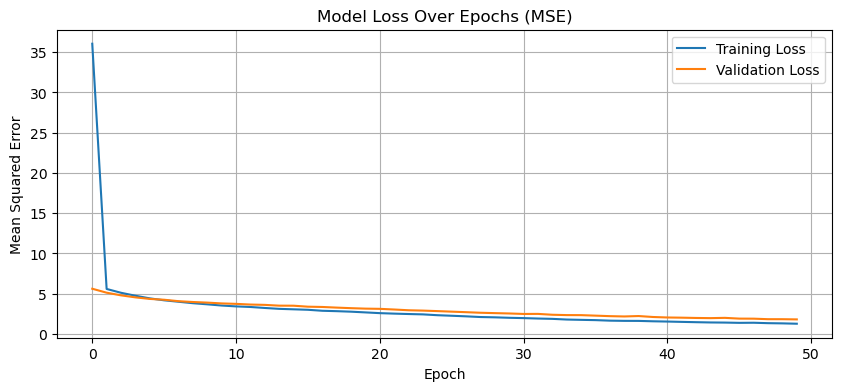

Validation RMSE: 1.3437
Validation Pearson Correlation (r): 0.8188
Validation Spearman Correlation (ρ): 0.5622


In [27]:
# --- Step 5: Evaluate Model Performance ---

print("\n--- Model Evaluation ---")

# Plot training & validation loss
plt.figure(figsize=(10, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions on the validation set
model.eval()
val_predictions_list = []
y_val_list = []
with torch.no_grad():
    # We use the val_loader again to avoid OOM on the full val set
    for inputs, labels in val_loader:
        val_predictions_list.append(model(inputs.to(device)))
        y_val_list.append(labels)

# Concatenate all batches and move to CPU
val_predictions_np = torch.cat(val_predictions_list, dim=0).cpu().numpy().flatten()
y_val_np = torch.cat(y_val_list, dim=0).cpu().numpy().flatten()

# Calculate evaluation metrics
val_rmse = root_mean_squared_error(y_val_np, val_predictions_np)
# Calculate Pearson Correlation (linear relationship)
val_pearson = pearsonr(y_val_np, val_predictions_np)[0]
# Calculate Spearman Correlation (rank relationship)
val_spearman = spearmanr(y_val_np, val_predictions_np)[0]

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation Pearson Correlation (r): {val_pearson:.4f}")
print(f"Validation Spearman Correlation (ρ): {val_spearman:.4f}")

In [28]:
# --- Step 6: Generate Final Predictions ---

print("\n--- Generating Final Predictions on Test Data ---")

# Create a DataLoader for the test set to prevent OOM
test_dataset = TensorDataset(X_test_tensor) # No labels
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
final_predictions_list = []
with torch.no_grad():
    for inputs in test_loader: # inputs is a list
        inputs_tensor = inputs[0].to(device)
        final_predictions_list.append(model(inputs_tensor))

# Concatenate all batches and move to CPU
final_predictions = torch.cat(final_predictions_list, dim=0).cpu().numpy().flatten()

# Display the first 10 predictions
print("First 10 automated scores:")
for i, score in enumerate(final_predictions[:10]):
    print(f"  Test Sample {i}: {score:.4f}")


--- Generating Final Predictions on Test Data ---
First 10 automated scores:
  Test Sample 0: 9.2290
  Test Sample 1: 9.3616
  Test Sample 2: 8.6748
  Test Sample 3: 9.6757
  Test Sample 4: 3.5591
  Test Sample 5: 9.4616
  Test Sample 6: 8.9469
  Test Sample 7: 7.8825
  Test Sample 8: 8.9346
  Test Sample 9: 7.3870
